In [17]:
import numpy as np
from PIL import Image, ImageDraw
from itertools import product

"""
********************************************************************************

Author Mike Woods

  This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>

********************************************************************************

The following annotated implementation of Ken Perlin's k-dimensional noise
is meant to serve as an easy-to-understand companion guide to a more in-depth
treatment of the algorithm. I wrote this code and the accompanying comments
mostly for myself in order to better understand how a gradient noise algorithm
like Perlin noise works. What better way to attempt to understand a topic
than to implement it and explain it? Granted, Perlin has been superceded by
newer noise methods, like Ken Perlin's own (patented) Simplex noise, and
the open source variant OpenSimplex noise, it is relatively easy to understand.
The only serious downside is it's algorithmic runtime. Perlin noise runs
in O(2^k), where k is the number of dimensions. For generating noise in higher
dimensions, Perlin noise can be *very* slow. Consider using Simplex/OpenSimplex
noise in such cases, as each algorithm will run in O(n^2), regardless of the
number of dimensions.

This code is based off of Mr. Perlin's improved version of the algorithm.
See his paper on the subject for more details
(http://mrl.nyu.edu/~perlin/paper445.pdf) or the slides from his talk,
"Making Noise" (http://www.noisemachine.com/talk1/)

Additionally, a reference implementation in C is available at
http://mrl.nyu.edu/~perlin/doc/oscar.html. While the code itself is clean,
there are no comments and the logic itself is fairly cryptic.

The description of the Perlin noise algorithm outlined on the corresponding
Wikipedia article is quite good and easy to follow:
https://en.wikipedia.org/wiki/Perlin_noise

For those that want a quick summary of the steps, here goes:

For k-dimensional noise,

[1] Discretize the world into N grid cells, then compute N unit-length
    k-dimensional vectors and store in a table. Assign one vector per cell
    corner. Each corner must have a unique vector assigned to it.

[2] For a given list of k-dimensional coordinates, compute the cell each
    coordinate falls within. Compute the relative unit position of the
    coordinate within the cell, where each cell dimension is bounded in the
    range [0.0, 1.0]. For k=2, and indices `i` and `j`, the 4 corners will
    be located at [(`i`, `j`), (`i`+1, `j`), (`i`, `j`+1), (`i`+1, `j`+1)]
    within the grid.

[3] For each unit coordinate position, compute 2^k unit vectors between the
    unit position and each corner of the cell. For k=2, position `p`, and
    corners `A`, `B`, `C`, and `D`, we compute 4 unit vectors:
    `p` - `A`, `p` - `B`, `p` - `C`, and `p` - `A`. After, compute the dot
    product between each unit vector from [3] and the gradient vector assigned
    to the corresponding corner.

[4] For each dimension up to k, linearly interpolate the results of the dot
    products, using each dimensional component of the unit position of the
    coordinate as the interpolation weight, as processed through the polynomial
    fade function `fade(t) = 6*t^5 -15*t^4 + 10*t^3`.

[5] Optional: rescale the output from the range [-1.0, 1.0] to [0.0, 1.0]

[6] Sample the noise at non-integer positions, e.g. <3.45, 6.45>, etc. This
    is necessary because the sampled noise will be 0 (or 0.5 if re-scale)
    at whole number coordinates. The simpliest way to do this is to simply
    multiply the sampling coordinates, say [0,0] to [w-1, h-1], where `w` is
    the width and `h` is the height of the sampling area by some sampling
    frequency. 1/16 is a good starting value. You can tweak the sampling
    frequency to produce noise at various "zoomed" levels. Try it yourself!
"""


"""The default sampling frequency to use when fetching noise values"""
DEFAULT_FREQ = 1.0 / 32.0


def dot(A, B):
    """For two (n, k) matrices, compute the dot product between them

    @param A numpy.ndarray[float] An ndarray where, A.shape=(n, k)
    @param B numpy.ndarray[float] An ndarray where, B.shape=(n, k)
    @returns An numpy.ndarray[float] vector of shape (n,)
    """
    assert A.shape == B.shape
    n, _ = A.shape
    return np.sum(A * B, axis=1)


def fade(t):
    """Computes the interpolation fade function, as determined by the
    polynomial 6*x^5 - 15*x^4 + 10*x^3
    """
    t3 = t * t * t
    t4 = t3 * t
    t5 = t4 * t
    return (6.0 * t5) - (15.0 * t4) + (10.0 * t3)


def lerp(A, B, t):
    """Linearly interpolates between two values based on some weight in the
    range [0.0, 1.0]

    @param A numpy.ndarray[float] Interpolant #1
    @param A numpy.ndarray[float] Interpolant #2
    @param t float The interpolation mix amount, in the range [0.0, 1.0]
    """
    return ((1.0 - t) * A) + (t * B)


def strides(k):
    """For a given number of dimensions k, this generator returns lists of
    index pairs

    * For k = 2:

        [[(0, 2), (1, 3)],
         [(0, 1)]]

    * For k = 3:

        [[(0, 4), (1, 5), (2, 6), (3, 7)],
         [(0, 2), (1, 3)],
         [(0, 1)]
    """
    stride = int(2 ** k)
    for i in range(k):
        L = range(0, stride)
        left = L[:stride // 2]
        right = L[stride // 2:]
        yield zip(left, right)
        stride //= 2


class NoiseKD(object):
    """Perlin noise generator in k-dimensions"""
    @classmethod
    def generate_gradients_vectors(cls, n, k):
        """Generates a numpy.ndarray[float] of `n` unit-length vectors for the
        given number of dimensions

        @param float n The number of vectors to generate
        @param float k The dimensionality of the generated vectors
        @returns A numpy.ndarray[float] of shape (n, k), where each row is
            a k-dimensional unit-length gradient vector
        """
        G = np.interp(np.random.rand(n, k), [0.0, 1.0], [-1.0, 1.0])
        return G / (np.tile(np.linalg.norm(G, axis=1).reshape(n, 1), (1, k)))

    def __init__(self, k, num_grads=512):
        """Initializes the noise generator

        @param k int The number of dimensions to generate noise for
        @param num_grads int. The number of possible gradient orientations to
        generate. The higher the number of gradients, the more "random"
        (and costly to generate) the underlying noise will appear to be
        """
        self.K = k

        # We generate `num_grads` gradient vectors of dimensionality k here
        self.GRADIENTS = self.generate_gradients_vectors(num_grads, k)
        self.NUM_GRADIENTS = num_grads

        # This will determine the size of the lookup table used to convert
        # a k-dimensioal cell index into an index used to look up the gradient
        # vector assigned to that particular cell corner
        self.GRADIENT_LOOKUP_SIZE = num_grads * 2

        # here, we actually build the gradient lookup table. The table
        # just contains the linear indices of each gradient vector. Right
        # now, entry 0 contains 0, entry 1 contains 1. etc. Generally speaking.
        # the i-th entry contains `i`
        self.GRADIENT_LOOKUP = \
          np.arange(self.GRADIENT_LOOKUP_SIZE).reshape((self.GRADIENT_LOOKUP_SIZE, 1))

        # and make things suffiently random: we shuffle the gradient lookup table
        # so that the i-th entry will not contain `i`, but some other number
        # in the range [0, `GRADIENT_LOOKUP_SIZE` - 1]
        np.random.shuffle(self.GRADIENT_LOOKUP)

    def find_gradient(self, cells):
        """Given a numpy.ndarray[int] of cell indices, `cells`, where
        cells.shape=(n, k), each row refers to a cell index in k-dimensional
        space.

        This method will return the indices of the k-dimensional gradient
        vector assigned to the i-th cell in `cells`.

        @param cells numpy.ndarray[int] A (n,k) numpy.ndarray of cell indices,
            where the i-th row specifies the indices of a given cell in
            k-dimensional space
        @returns numpy.ndarray[float] A n-element vector containing the
           index of the i-th gradient vector for the i-th cell given in `cells``
        """
        n, k = cells.shape
        assert k == self.K

        # Below is a simple hashing scheme that differs from Ken Perlin's
        # hashing approach. My scheme is simpler, and may produce more collisions
        # (more cell indices mapping to the same gradient vector), but in
        # practice it works pretty well and is easy to understand.
        # Generally, I choose to make `GRADIENT_LOOKUP_SIZE` twice the number
        # of gradient vectors. This seems to reduce the likelihood of a collision,
        # but I don't have any empirical proof to back that up, so you'll just
        # have to trust me (for now :-)).

        # Given the cell indices in each dimension, we convert the cells into
        # indices in the `GRADIENT_LOOKUP` table, being careful to constrain
        # cell indices to the size of `GRADIENT_LOOKUP` by taking the
        # cell index modulo `GRADIENT_LOOKUP_SIZE`
        hash_per_dim = self.GRADIENT_LOOKUP[cells % self.GRADIENT_LOOKUP_SIZE, :].reshape(((n, k)))

        # Next, we add the index values together across all dimensions. So,
        # instead of having (n, k) index values that correspond to index values
        # in `GRADIENT_LOOKUP`, we have (n, 1) sums.
        combined_hash = np.sum(hash_per_dim, axis=1)

        # In order to make the values in `combined_hash` valid index values
        # (since they most likely fall outside the range [0, GRADIENT_LOOKUP_SIZE - 1])
        # now, we compute `combined_hash` modulo `GRADIENT_LOOKUP_SIZE`
        hash_index = combined_hash % self.GRADIENT_LOOKUP_SIZE

        # Finally, we constrain the indices to the valid range of gradient
        # vector indices by using `hash_index` as an index into `GRADIENT_LOOKUP`
        # and computing the modulo `NUM_GRADIENTS` of the resulting values.
        # This will provide us with the needed indices in the range
        # [0, `NUM_GRADIENTS` - 1]
        return self.GRADIENT_LOOKUP[hash_index, :].reshape((n, )) % self.NUM_GRADIENTS

    def coords_to_cells_and_unit_vectors(self, coords):
        """Given a numpy.ndarray[float] of coordinates `coords` with
        coords.shape=(n, k), this method returns 3-tuple of the following:

        [1] A numpy.ndarray[int] with shape=(n, k), where the i-th row contains
        the integer indices of the unit (hyper-)cube) "cell" the i-ith
        coordinate in `coords` is contained within

        [2] A numpy.ndarray[float] with shape=(n, k), where the i-th row contains
        the relative position of the i-th coordinate in `coords` within the unit
        (hyper-)cube denoted by [1]

        [3] A numpy.ndarray[float] with shape=(n, k) that serves as the
        interpolation weights that will be used later to determine the relative
        weights of the computed dot product. After interpolating all of the
        dot products in k-dimensions, we will have our final output value
        for the i-th coordinate

        @param ndarray[float] coords An ndarray, where coords.shape=(n, k).
        Each row of coords represents a point in k-dimensional space
        @returns (numpy.ndarray[float], numpy.ndarray[float], numpy.ndarray[float])
        """

        # We expect `coord` to contain rows, each one specifying a point in
        # k-dimensional space. For two dimensional points, coords will look like
        # [[1.2, 45.6], ...], for three dimensional space, coords will look like
        # [[1.2, 45.6, -4.7], ...], and so on.
        n, k = coords.shape
        assert k == self.K

        # First, we compute the integer position of each coordinate. This integer
        # (whole number) value will serves as the origin (think of it as the
        # "left" point for 1-D, "bottom-right" point for 2-D,
        # bottom-right-front for 3D, etc.), of the cell's unit (hyper-)cube:
        whole_pos = coords.astype(int)

        # The decimal position is (as the name implies) the decimal portion of
        # the given coordinate(s). This value is position of the coordinate in
        # unit space, e.g. the relative position of the coordinate inside the
        # unit cell, where each dimension of the cell is bounded to the range
        # [0.0, 1.0]. So for instance, given the coordinate # <6.456, 9.923>,
        # the coordinate would be located in cell <6,9> and the relative
        # position of the coordinate in the unit cell would be <0.456, 0.923>
        decimal_pos = coords - coords.astype(int)

        # For k dimensions, we store 2^k vectors:
        count = 2 ** k

        # We create a numpy.ndarray of shape (n, k, 2^k) here since for each
        # coordinate in `coords`, we need to store 2^k cell index tuples/unit
        # vectors, each of dimensionality k (which means each will have k
        # components)
        cells = np.zeros((n, k, count), dtype=int)
        unit_vectors = np.zeros((n, k, count), dtype=float)

        # For k dimensions, we compute n * (2^k) offset vectors. For a
        # list of elements=[0.0, 1.0], product(elements, repeat=2), returns
        # a list of length 4, where each entry is a 2-tuple;
        # product(elements, repeat=3), returns a list of length 8, where each
        # entry is a 3-tuple (more details on this below)
        for i, offset in enumerate(product([0.0, 1.0], repeat=k)):

            # Aside: if we don't copy, we'll just alias existing arrays,
            # inadvertently modifying the source array, since we'll be mutating
            # the arrays via the `+=` and `-=` operators later
            cells[:, :, i] = whole_pos.copy()
            unit_vectors[:, :, i] = decimal_pos.copy()

            # Now, to get a clearer idea of what we'll be doing, imagine the
            # following 2D diagram of a given cell, defined by
            # 4 corners (`A`, `B`, `C`, `D`), containing a point `p`.
            #
            # (C)-------(D)  Let `A` = (6, 13)
            #  |\       /|       `B` = (7, 13)
            #  | \     / |       `C` = (6, 14)
            #  |  \   /  |       `D` = (7, 14)
            #  |   (p)   |
            #  |  /   \  |   Additionally, let the unit coordinates of `p`
            #  | /     \ |   be (0.45, 0.67)
            #  |/       \|
            # (A)-------(B)
            #
            # For a given array of coordinates, our goal in this method is
            # two-fold:
            #
            # [1] For each coordinate `c`, compute the indices of the 4 vertices
            # defining the extent of the unit (hyper-)cube cell `c` is
            # contained within.
            #
            # Remember, since we're in 2D, we need 4 vertices/corners to define
            # a square:
            #
            #   [(i, j), (i+1, j), (i, j+1), (i+1, j+1)]
            #
            # Similary for 3D, we need 8 corners/vertices to define a cube:
            #
            #   [(i, j, k),
            #    (i, j, k+1),
            #    (i, j+1, k),
            #    (i, j+1, k+1),
            #    (i+1, j, k),
            #    (i+1, j, k+1),
            #    (i+1, j+1, k),
            #    (i+1, j+1, k+1)]
            #
            # In general, for dimensionality k, we need 2^k corners/vertices to
            # define the unit hyper-cube cell containing `c`. The 2 comes from
            # the fact that we only choose two possible values for our offsets,
            # [0 and 1]. Something like [(i, j), (i+1, j), (i, j+1), (i+1, j+1)]
            # could just as easily be written as
            #
            #  [(i+0, j+0), (i+1, j+0), (i+0, j+1), (i+1, j+1)]
            #
            # [2] Using the 2^k corners/vertices, we compute 2^k unit vectors
            # from each corner (`A`, `B`, `C`, `D`, in 2 dimensions) to the
            # point `p`. This operation is actually very simple. Since each
            # corner/vertex is part of a unit (hyper-)cube, the corresponding
            # coordinate for each is composed of components (x,y,z,etc.) that
            # are either 0 or 1. For instance, in 2 dimensions, the vertices
            # of the square `p` is contained in is
            # [(0, 0), (1, 0), (0, 1), (1, 1)] (notice any similarities with
            # cell indices [(i, j), (i+1, j), (i, j+1), (i+1, j+1)]?) All that's
            # needed then is to subtract every vertex of the unit (hyper-)cube
            # from `p`, e.g. `p` - (0, 0), `p` - (1, 0), `p`- (0, 1), and
            # `p` - (1, 1). For k dimensions, 2^k operations will need to be
            # performed.
            for dim in range(k):
                # Part [1], as described above...
                cells[:, dim, i] += int(offset[dim])
                # ... and part [2]
                unit_vectors[:, dim, i] -= float(offset[dim])

        return cells, unit_vectors, decimal_pos

    def raw_noise(self, coords, rescale=True):
        """This method allows for sampling of the coherent noise gradient
        distribution directly (see https://upload.wikimedia.org/wikipedia/commons/d/da/Perlin_noise.jpg
        for a visual example). We can use the raw sampled values to generate
        more interesting types of coherent noise (see below)

        @param coords numpy.ndarray[float] The input sampling coordinates.
            Note that it is very important to sample at non-integer positions,
            e.g. <3.45, 6.45>, etc. This is necessary because the sampled noise
            will be 0 (or 0.5 if re-scale) at whole number coordinates. The
            simpliest way to do this is to simply multiply the sampling
            coordinates, say [0,0] to [w-1, h-1], where `w` is the width and
            `h` is the height of the sampling area by some sampling frequency
            like 1/16, etc.

        @param rescale bool If True, returned noise values will be converted
            from the range [-1.0, 1.0] to [0.0, 1.0]
        @returns numpy.ndarray[float] A numpy.ndarray[float] (vector) with shape
            (n,), where the i-th entry corresponds to the sampled noise value
            for the i-th coordinate in `coords`
        """
        n, k = coords.shape
        assert k == self.K

        # Here, we put the pieces together:
        cells, unit_vectors, fade_amount = self.coords_to_cells_and_unit_vectors(coords)

        # Apply the fade function prior to interpolation. We can use the raw
        # `fade_amount` values in place of `weights`, however if we do this
        # the sampled noise will have a noticeable grid-like appearance
        weights = fade(fade_amount)

        # This will hold all of our intermediate interpolated values. After
        # everything is done, Y[:, 0] will contain the final noise values
        # that we can either rescale and return, or just return directly.
        Y = np.zeros((n, 2 ** k))

        strides_ = list(strides(k))

        # In the first dimension, we compute the dot product between all
        # gradient vectors and unit vectors. In 2D (k=2), given a grid cell
        # with integer indices `i` and `j`, we will compute the dot product
        # between gradients vectors and unit vectors at (i, j), (i + 1, j),
        # (i, j + 1), and (i + 1, j + 1) and linearly interpolate ("lerp")
        # the results of the dot product at (i, j)/(i + 1, j) (call this `x0`)
        # and (i, j + 1)/(i + 1, j + 1) (call this `x1`). We also use the
        # interpolation weights in the 1st/"x" dimension both times. Next
        # we lerp again, this time with values `x0` and `x1`, using the
        # interpolation weights in the 2nd /"y" dimension. Viola! We're done
        # (unless we choose not to rescale the values).
        for (i, j) in strides_[0]:
            Y[:, i] = dot(self.GRADIENTS[self.find_gradient(cells[:, :, i]), :], unit_vectors[:, :, i])
            Y[:, j] = dot(self.GRADIENTS[self.find_gradient(cells[:, :, j]), :], unit_vectors[:, :, j])

        # This code is a little more complex than what's described above, but
        # it's still doing the same thing, except this generalizes for
        # dimensions > 3.
        for w, s in enumerate(strides_):
            for (i, j) in s:
                Y[:, i] = lerp(Y[:, i], Y[:, j], weights[:, w])

        # Rescaling in this context simply means proportionally scaling an
        # array of values where each value lies in an old range, e.g.
        # [-1.0, 1.0], such that new values fall in a new range ([0.0, 1.0]
        # for instance).
        return np.interp(Y[:, 0], [-1.0, 1.0], [0.0, 1.0]) if rescale else Y[:, 0]

    def fractal_noise(self, coords, freq=DEFAULT_FREQ, octaves=5, persistence=0.5, lacunarity=2.0, rescale=True):
        """Now for something interesting: fractal noise basically takes (dull)
        raw Perlin noise and makes it more interesting by successively adding
        layers of noise together to create a more complex noise composition.

        This is accomplished as follows

        For each output pixel, we iterate for N "octaves", each time, sampling
        the raw Perlin noise at different frequencies, damping the result
        of each iteration by some amount and adding everything together.

        https://code.google.com/p/fractalterraingeneration/wiki/Fractional_Brownian_Motion
        serves as a good explanation of the various parameters. I'll try to
        explain what each parameter does below:

       `freq`: This determines the initial sampling frequency of the noise, e.g.
            how "close" or "far" apart our samples are taken of the underlying
            raw Perlin noise. Adjusting this parameter will determine how
            "big" or "small" the noise features appear. Try playing around
            with this parameter. It can how dramatic effects on the final
            output. In general, the larger the sampling value, the "smaller"
            the noise features will appear. Ideal values fall in the range
            [0.0, 1.0].

        `octaves`: This determines the number of iterations of sampling that
            will occur. Fewer octaves will yield less detailed noise, whereas
            more octaves will produce more detailed noise. The downsize for
            larger octaves however, is that the final noise will take longer
            to compute. For instance, if octaves is 5, we will have to
            sample the raw noise 5 times. Ideal values fall in the range
            [3, 7].

        `persistence`: Peristence is the damping factor that is applied to the
            sampled noise value per octave. It basically controls how much
            the given sample at the current octave will contribute to the
            final noise value for a given pixel, e.g. it's "importance".
            For example, say our beginning persistence value is 0.5.
            For the first octave, the sampled noise value will contribute 0.5, or
            50% to the final value of the output. For the next sample, we will
            take 50% of the previous persistence value, which will be 0.25, or
            25%. Next, we'll take 50% of 0.25, yielding 0.125 of 12.5%, and so
            on. The default persistence value of 0.5 is generally the most
            useful.

        `lacunarity`: Despite the strangeness of the name, lacunarity does
            something simple: it's just the rate by which the sampling frequency
            changes for each octave. For example, if our starting frequency is
            1/16 and our lacunarity is 2.0, then for the first octave, we sample
            at 1/16, the next we sample at 1/16*2.0 = 1/8, the next at
            1/16*2.0*2.0 = 1/4, and so on. The default persistence value of 2.0
            is generally the most useful.

        @param coords numpy.ndarray[float] An array of sampling coordinates
            of shape (n, k), where k is the number of dimensions
        @param freq float
        @param octaves int
        @param persistence float
        @param lacunarity float
        @returns numpy.ndarray
        """
        n, k = coords.shape
        assert k == self.K

        values = np.zeros((n,))
        amp = persistence

        for i in range(octaves):
            values += self.raw_noise(coords * freq, rescale=rescale) * amp
            freq *= lacunarity
            amp *= persistence

        return values

    def ridged_noise(self, coords, freq=DEFAULT_FREQ, octaves=5, persistence=0.5, lacunarity=2.0):
        """A variation of fractal noise that produces noise with ridges, like
        a mountain range

        @param coords numpy.ndarray[float] An array of sampling coordinates
            of shape (n, k), where k is the number of dimensions
        @param freq float
        @param octaves int
        @param persistence float
        @param lacunarity float
        @returns numpy.ndarray
        """
        base_noise = self.fractal_noise(coords, octaves=octaves, persistence=persistence, freq=freq, rescale=False)
        return 0.5 - np.abs(base_noise)


def display(w, h, noise_values, path='.'):
    def intensity_to_rgb(value):
        v = int(value * 255.0)
        return (v, v, v)

    if len(noise_values.shape) == 3:
        _, _, frames = noise_values.shape
        is_3d = True
    else:
        is_3d = False
        frames = 1

    for frame in range(frames):
        image = Image.new("RGB", (w, h))
        pixels = image.load()
        for i in range(w):
            for j in range(h):
                if is_3d:
                    pixels[i, j] = intensity_to_rgb(noise_values[i, j, frame])
                else:
                    pixels[i, j] = intensity_to_rgb(noise_values[i, j])
        if is_3d:
            print("Writing frame: {n:0>5}".format(n=frame))
            output = "{path}/image_{n:0>5}.png".format(path=path, n=frame)
        else:
            output = "{path}/image.png".format(path=path)
        with open(output, 'w') as f:
            image.save(f, format="png")
        if not is_3d:
            image.show()


def raw_noise_in_2d_example(w=200, h=200, freq=DEFAULT_FREQ):
    """A raw 2D noise example

    @param w int The width of the example image
    @param h int The height of the example image
    @param freq float The sampling frequency
    """
    noise = NoiseKD(2)
    coords = np.array([[i, j] for i in range(w) for j in range(h)])
    values = noise.raw_noise(coords * freq)
    display(w, h, values.reshape((w, h)))


def raw_noise_in_3d_example(w=200, h=200, frames=100, freq=DEFAULT_FREQ):
    """A raw 2D noise example, that uses the third dimension for animation

    @param w int The width of the example image
    @param h int The height of the example image
    @param frames in The number of frames in the animation
    @param freq float The sampling frequency
    """
    noise = NoiseKD(3)
    coords = np.array([[i, j, k] for i in range(w) for j in range(h) for k in range(frames)])
    values = noise.raw_noise(coords * freq)
    display(w, h, values.reshape((w, h, frames)))


def fractal_noise_in_2d_example(w=200, h=200):
    """A fractal noise 2D noise example_ @param w int The width of the example image
    @param h int The height of the example image
    """
    noise = NoiseKD(2)
    coords = np.array([[i, j] for i in range(w) for j in range(h)])
    values = noise.fractal_noise(coords, freq=1.0/64.0, octaves=6)
    display(w, h, values.reshape((w, h)))


def fractal_noise_in_3d_example(w=200, h=200, frames=100):
    """A fractal 2D noise example, that uses the third dimension for animation

    @param w int The width of the example image
    @param h int The height of the example image
    @param frames in The number of frames in the animation
    @param freq float The sampling frequency
    """
    noise = NoiseKD(3)
    coords = np.array([[i, j, k] for i in range(w) for j in range(h) for k in range(frames)])
    values = noise.fractal_noise(coords, freq=1.0/64.0, octaves=6)
    display(w, h, values.reshape((w, h, frames)))


def ridged_noise_in_2d_example(w=200, h=200):
    """A ridged noise 2D noise example

    @param w int The width of the example image
    @param h int The height of the example image
    """
    noise = NoiseKD(2)
    coords = np.array([[i, j] for i in range(w) for j in range(h)])
    values = noise.ridged_noise(coords, freq=1.0/64.0, octaves=6)
    display(w, h, values.reshape((w, h)))


def ridged_noise_in_3d_example(w=200, h=200, frames=100):
    """A ridged 2D noise example, that uses the third dimension for animation

    @param w int The width of the example image
    @param h int The height of the example image
    @param frames in The number of frames in the animation
    """
    noise = NoiseKD(3)
    coords = np.array([[i, j, k] for i in range(w) for j in range(h) for k in range(frames)])
    values = noise.ridged_noise(coords, freq=1.0/64.0, octaves=6)
    display(w, h, values.reshape((w, h, frames)))


#raw_noise_in_2d_example()
#raw_noise_in_3d_example()
#fractal_noise_in_2d_example()
#fractal_noise_in_3d_example()
#ridged_noise_in_2d_example()
#ridged_noise_in_3d_example()

In [18]:
w,h = 500,500
noise = NoiseKD(2)
coords = np.array([[i, j] for i in range(w) for j in range(h)])
values = noise.fractal_noise(coords, freq=1.0/64.0, octaves=6)
values = values.reshape((w, h))


In [10]:
from pylab import *
%matplotlib inline

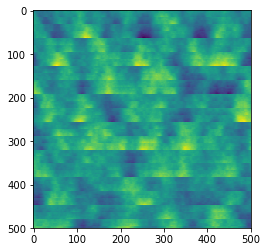

In [19]:
imshow(values)